In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os



/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
data = np.load('/mnt/data/ml/ShowJetsDataLabels.npz')
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']


nVar = len(data) - 5 # excluding pt, eta, phi, images, and labels

tau21 = data['tau21']
chMult = data['chMult']
neutMult = data['neutMult']
phoMult = data['phoMult']
eleMult = data['eleMult']
muMult = data['muMult']

## data = stack all of them, then split them up after

grid = np.size(images, 1)
qcd_im = images[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]
qcd_phoMult = phoMult[np.where(labels[:,0] == 1)]

#ensure same number of signal vs. background and even split of z events
if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_tau = qcd_tau[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_mult = qcd_mult[:len(qcd_im)-(len(qcd_im) % 3)]
    qcd_phoMult = qcd_phoMult[:len(qcd_im)-(len(qcd_im) % 3)]
    
z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z1_tau = tau21[np.where(labels[:,1] == 1)]
z1_tau = z1_tau[:int(len(qcd_im)/3)]
z1_mult = chMult[np.where(labels[:,1] == 1)]
z1_mult = z1_mult[:int(len(qcd_im)/3)]
z1_phoMult = phoMult[np.where(labels[:,1] == 1)]
z1_phoMult = z1_phoMult[:int(len(qcd_im)/3)]

z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z2_tau = tau21[np.where(labels[:,2] == 1)]
z2_tau = z2_tau[:int(len(qcd_im)/3)]
z2_mult = chMult[np.where(labels[:,2] == 1)]
z2_mult = z2_mult[:int(len(qcd_im)/3)]
z2_phoMult = phoMult[np.where(labels[:,2] == 1)]
z2_phoMult = z2_phoMult[:int(len(qcd_im)/3)]

z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
z3_tau = tau21[np.where(labels[:,3] == 1)]
z3_tau = z3_tau[:int(len(qcd_im)/3)]
z3_mult = chMult[np.where(labels[:,3] == 1)]
z3_mult = z3_mult[:int(len(qcd_im)/3)]
z3_phoMult = phoMult[np.where(labels[:,3] == 1)]
z3_phoMult = z3_phoMult[:int(len(qcd_im)/3)]

qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1

images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
taus = np.hstack((qcd_tau, z1_tau, z2_tau, z3_tau))
mults = np.hstack((qcd_mult, z1_mult, z2_mult, z3_mult))
phoMults = np.hstack((qcd_phoMult, z1_phoMult, z2_phoMult, z3_phoMult))
print(labels.shape)

labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)

#split data into testing/training/validation

testimages = images[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]
testphoMults = phoMults[::4]

mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0

mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0
mask_phoMult = np.ones(phoMults.shape,dtype=bool)
mask_phoMult[::4] = 0
mask_phoMult[1::8] = 0

valimages = images[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]
valphoMults = phoMults[1::8]

trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)
traintaus = taus[mask_tau].reshape((n_data-len(testimages)-len(valimages)), 1)
trainmults = mults[mask_mult].reshape((n_data-len(testimages)-len(valimages)), 1)
trainphoMults = phoMults[mask_phoMult].reshape((n_data-len(testimages)-len(valimages)), 1)

print(trainimages.shape)
print(trainlabels.shape)
print(traintaus.shape)
print(trainmults.shape)
print(trainphoMults.shape)
print()
print(valimages.shape)
print(vallabels.shape)
print(valtaus.shape)
print(valmults.shape)
print(valphoMults.shape)
print()
print(testimages.shape)
print(testlabels.shape)
print(testtaus.shape)
print(testmults.shape)
print(testphoMults.shape)


(336227, 4)
(62025, 16, 16, 1)
(62025, 2)
(62025, 1)
(62025, 1)
(62025, 1)

(12405, 16, 16, 1)
(12405, 2)
(12405,)
(12405,)
(12405,)

(24810, 16, 16, 1)
(24810, 2)
(24810,)
(24810,)
(24810,)


In [3]:
print(labels.shape)

(99240, 2)


In [4]:
# nVar = 5
# variables= []
# print(variables)
# for i in data:
#     temp = {"name":str(i),
#            "data":data[str(i)]}
#     variables.append(temp)

# #print(variables.get('tau21')

    

In [5]:
### trying to make adding variable easier ###

# data = np.load('/mnt/data/ml/ShowJetsDataTest.npz')
# varlist = ['tau21', 'chMult']
# nVar = len(varlist)
# temp = np.zeros((nVar, labels.shape[0]))
# for n in range(nVar):
#     temp[n] = data[varlist[n]]
    

# var = np.vstack((temp))
# qcd_var = var[:, np.where(labels[:,0] == 1)]

# #print(np.where(labels[:,0] == 1))
# arg = np.where(labels[:,0] == 1)
# print(arg)
# print(qcd_tau)
# print(var[:,286606])
# print(var.shape)
# print(labels.shape)


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

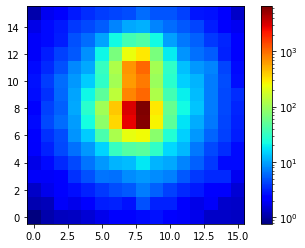

In [6]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

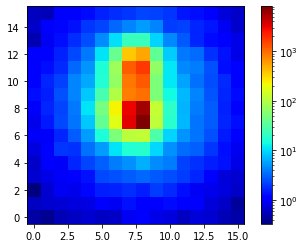

In [7]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
import tensorflow as tf

def build_model(n):
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(64, (12, 12), activation='relu', padding = 'same')(input1)
    x = layers.Conv2D(64, (6, 6), activation='relu', padding = 'same')(x)
    x = layers.Conv2D(64, (4, 4), activation='relu', padding = 'same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    inpts = []
    for i in range(n):
        inpt = layers.Input(shape=(1,))
        inpts.append(inpt)
    x = layers.concatenate(inputs = [x1]+inpts, axis=-1)
    x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation=tf.nn.sigmoid)(x)
    model = models.Model(inputs=[input1]+inpts, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [9]:
#circleCNN = build_model()

Test model's prediction $before$ training:

In [10]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
example_taus = traintaus[::300]
example_mults = trainmults[::300]
example_phoMults = trainphoMults[::300]

print(example_batch.shape)
print(example_mults.shape)

example_variables = [example_batch, 
                     example_taus,
                     example_mults,
                     #example_neutMults,
                     example_phoMults,
                     #example_eleMults,
                     #example_muMults
                    ]
                             
train_variables = [trainimages,
                   traintaus,
                   trainmults,
                   #trainNeutMults,
                   trainphoMults,
                   #trainEleMults,
                   #trainMuMults
                  ]

test_variables = [testimages, 
                   testtaus,
                   testmults,
                   #testNeutMults,
                   testphoMults,
                   #testEleMults,
                   #testMuMults
                  ]




(207, 16, 16, 1)
(207, 1)


In [11]:
circleCNN = build_model( len(example_variables)-1 )

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
example_result = circleCNN.predict(x = example_variables)
results = circleCNN.evaluate(x = example_variables, y = example_labels)
print(example_result)
#print(results)

207/207 [==============================] - 0s 2ms/step
[[0.44560313 0.3718795 ]
 [0.47958586 0.4383938 ]
 [0.4596685  0.37970847]
 [0.4727233  0.40351242]
 [0.49219075 0.46370137]
 [0.44352594 0.30927628]
 [0.4708218  0.39330488]
 [0.46806476 0.39644474]
 [0.45571378 0.37204224]
 [0.40313047 0.27869844]
 [0.4242698  0.34968442]
 [0.46264786 0.4043302 ]
 [0.45321742 0.3581766 ]
 [0.43602675 0.35066926]
 [0.45563433 0.39597857]
 [0.47478038 0.41375703]
 [0.48442137 0.40509862]
 [0.46618238 0.38074374]
 [0.46975932 0.38834718]
 [0.4482125  0.41381243]
 [0.43695217 0.2983932 ]
 [0.4711566  0.3881803 ]
 [0.46491516 0.38139927]
 [0.45321676 0.3522541 ]
 [0.47064334 0.39887768]
 [0.41695166 0.2692457 ]
 [0.47022453 0.41674176]
 [0.4468     0.32588467]
 [0.41947174 0.36700165]
 [0.47303087 0.44751915]
 [0.49588418 0.4340474 ]
 [0.4801859  0.42424703]
 [0.4831109  0.29492244]
 [0.3883512  0.31569177]
 [0.41057923 0.30430874]
 [0.4234246  0.28339252]
 [0.48860812 0.45586056]
 [0.37402785 0.24936

Now train! (warning: if building CNN, computer tends to get loud)

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/CNN_cat_multi_input_tau_chmult_phomult2.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = circleCNN.fit(
  train_variables, trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.44972, saving model to model/CNN_cat_multi_input_tau_chmult_phomult.h5

Epoch 00002: val_loss did not improve from 0.44972

Epoch 00003: val_loss did not improve from 0.44972

Epoch 00004: val_loss did not improve from 0.44972

Epoch 00005: val_loss did not improve from 0.44972

Epoch 00006: val_loss did not improve from 0.44972

Epoch 00007: val_loss improved from 0.44972 to 0.40676, saving model to model/CNN_cat_multi_input_tau_chmult_phomult.h5

Epoch 00008: val_loss did not improve from 0.40676

Epoch 00009: val_loss did not improve from 0.40676

Epoch 00010: val_loss did not improve from 0.40676

Epoch 00011: val_loss did not improve from 0.40676

Epoch 00012: val_loss did not improve from 0.40676

Epoch 00013: val_loss did not improve from 0.40676

Epoch 00014: val_loss did not improve from 0.40676

Epoch 00015: val_loss did not improve from 0.40676

Epoch 00016: val_loss did not improve

In [14]:
#dataset_shuffled = dataset.shuffle(buffer_size=1024).batch(16)

In [15]:
# # WITH BATCHING AND SHUFFLING



# EPOCHS = 1
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = circleCNN.fit(
#   dataset_shuffled,
#   epochs=EPOCHS)

Now make a plot that shows the pregression of accuracy through each training epoch.

In [16]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'], hist['mean_squared_error'],
#              label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#              label = 'Val Error')
#     plt.ylim([0,100])
#     plt.legend()
#     plt.show()

# plot_history(history)

Load best weights.

In [14]:
!ls model
best_model = keras.models.load_model('model/CNN_cat_multi_input_tau_chmult_phomult.h5')
best_model.summary()
results = best_model.evaluate(test_variables, testlabels)
print(results)

CNN_cat_multi_7inputs.h5
CNN_cat_multi_input_3inputs.h5
CNN_cat_multi_input_4inputs.h5
CNN_cat_multi_input_5E.h5
CNN_cat_multi_input.h5
CNN_cat_multi_input_tau_chmult_5epochs.h5
CNN_cat_multi_input_tau_chmult_phomult_5epochs.h5
CNN_cat_multi_input_tau_chmult_phomult.h5
CNN_cat_multi_input_taus.h5
CNN_sparce_cat.h5
RNN.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   147520      conv2d_1[0][0]    

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

(24810,)
(24810, 16, 16, 1)
(24810, 2)


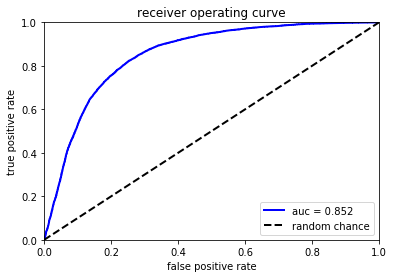

In [15]:
# Plot ROC

print(testtaus.shape)
print(testimages.shape)
print(testlabels.shape)

#predict = best_model.predict([testimages, testtaus, testmults])
predict = best_model.predict(test_variables)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,0], predict[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

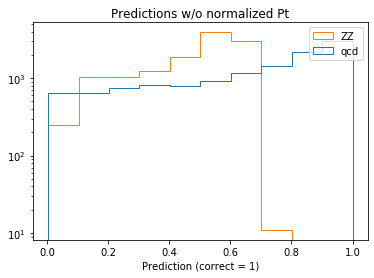

In [16]:
indqcd = np.argwhere(testlabels[:,1] == 0)
ind1  = np.where(testlabels[:,1] == 1) 
#ind2  = np.where(testlabels[:,2] == 1)
#ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()] , histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()

$$ \textbf{LRP} $$

In [ ]:
# import innvestigate
# import innvestigate.utils as iutils

In [ ]:
# # Creating an analyzer
# lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
# #discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# # Applying the analyzer
# display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
# analysis = lrp_analyzer.analyze(display)

# # Displaying one result
# plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [ ]:
# #fix - change to predicted labels
# #plot output signal and background
# sig_analysis_true = np.zeros_like(analysis)
# bkg_analysis_true = np.zeros_like(analysis)
# sig_analysis_pred = np.zeros_like(analysis)
# bkg_analysis_pred = np.zeros_like(analysis)
# # sig_mask = trainlabels == 1
# # bkg_mask = trainlabels == 0
# # pred_sig_mask = predict >= 0.50
# # pred_bkg_mask = predict < 0.50

# toc = time.time()

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] == 1:
#         sig_analysis_true += analysis  
#     else:
#         bkg_analysis_true += analysis

# for i in range(len(trainimages)):
#     display = trainimages[i].reshape(1,grid,grid,1)
#     analysis = lrp_analyzer.analyze(display)
#     if trainlabels[i] >= 0.50:
#         sig_analysis_pred += analysis  
#     else:
#         bkg_analysis_pred += analysis

# tic = time.time()

# print('/n time = /n', tic-toc)


In [ ]:
# Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# ax.add_subplot(121)
# im = plt.imshow(sig_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)
# ax.add_subplot(122)
# im_ = plt.imshow(sig_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)

In [ ]:
# # Displaying the signal result
# ax = plt.figure(figsize = (10,10))
# plt.subplot(121)
# im_ = plt.imshow(bkg_analysis_true.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im_,fraction=0.046, pad=0.04)
# plt.subplot(122)
# im = plt.imshow(bkg_analysis_pred.squeeze(), cmap='seismic', interpolation='nearest')
# plt.colorbar(im,fraction=0.046, pad=0.04)